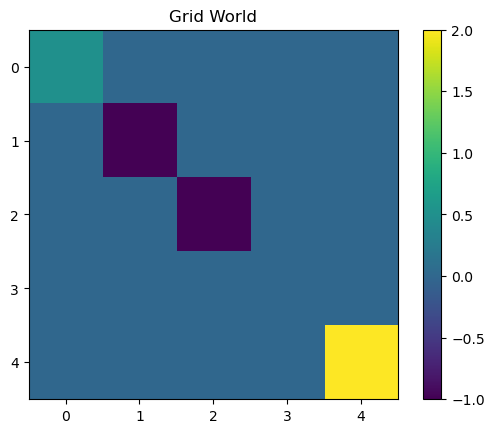

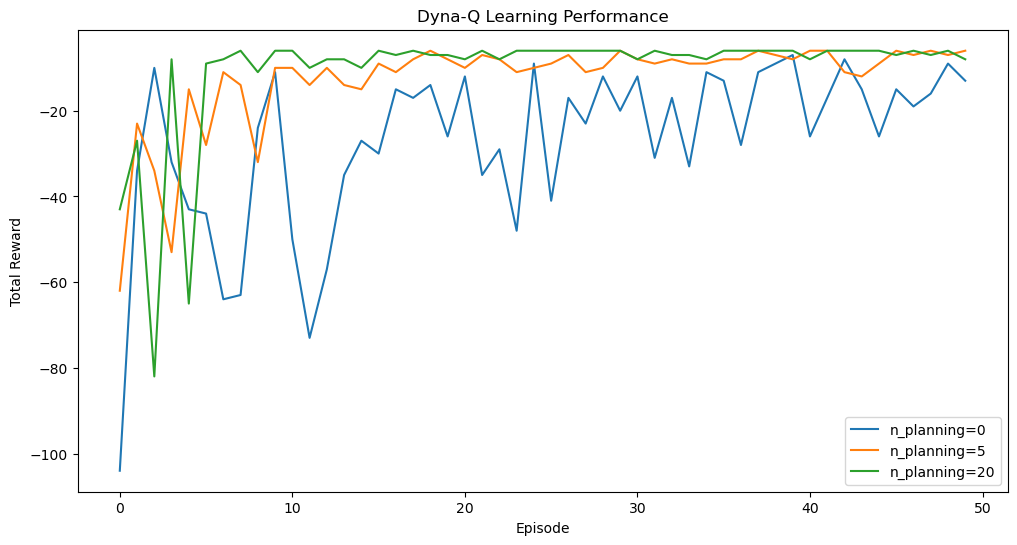

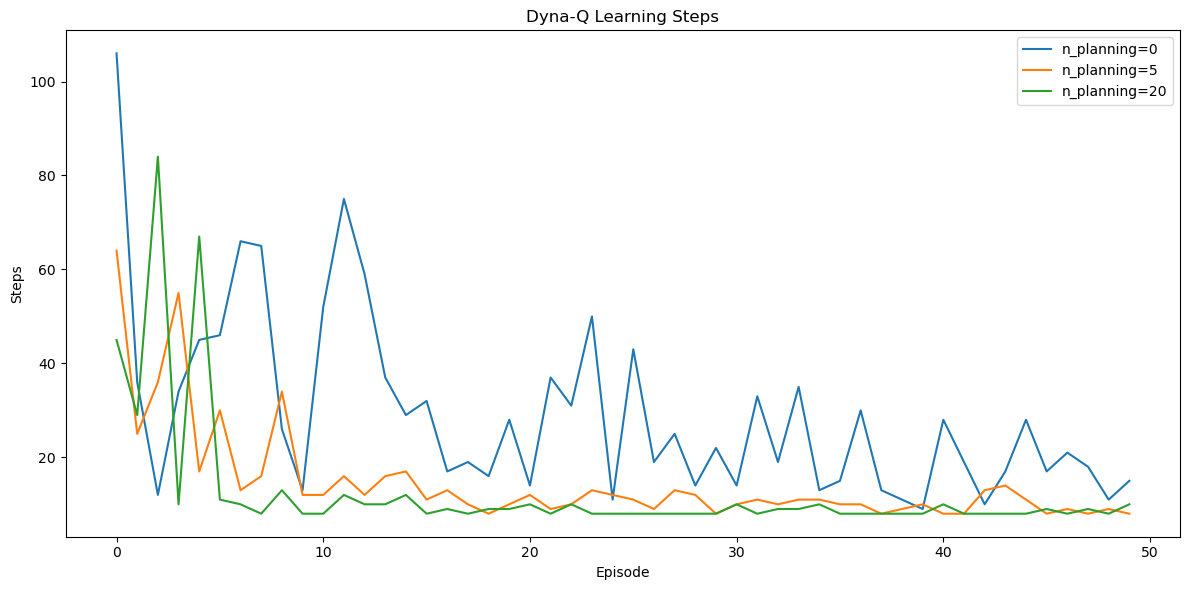

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 定义环境
class GridWorld:
    def __init__(self, width, height, goal, obstacles):
        self.width = width
        self.height = height
        self.goal = goal  # 目标位置 (x, y)
        self.obstacles = obstacles  # 障碍物列表 [(x1, y1), (x2, y2), ...]
        self.actions = ['up', 'down', 'left', 'right']  # 可能的动作

    def reset(self):
        # 固定初始位置为 (0, 0)
        self.agent_pos = (0, 0)
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos
        if action == 'up':
            y = max(y - 1, 0)
        elif action == 'down':
            y = min(y + 1, self.height - 1)
        elif action == 'left':
            x = max(x - 1, 0)
        elif action == 'right':
            x = min(x + 1, self.width - 1)

        # 检查新位置是否是障碍物
        if (x, y) in self.obstacles:
            x, y = self.agent_pos  # 保持原位置

        self.agent_pos = (x, y)

        # 到达目标则奖励为 1，否则为 0
        reward = 1 if (x, y) == self.goal else -1
        done = (x, y) == self.goal

        return (x, y), reward, done
    
    def visualize(self):
        # 创建网格
        grid = np.zeros((self.height, self.width))

        # 标记障碍物
        for obstacle in self.obstacles:
            grid[obstacle[1], obstacle[0]] = -1

        # 标记目标
        grid[self.goal[1], self.goal[0]] = 2

        # 标记初始位置
        grid[0, 0] = 0.5

        # 绘制网格
        plt.imshow(grid, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.title("Grid World")
        plt.show()


# Dyna-Q 算法
class DynaQ:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, n_planning=5):
        self.env = env
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # 探索率
        self.n_planning = n_planning  # 每次实际交互后的规划次数

        # 初始化 Q 表
        self.Q = {}
        for x in range(env.width):
            for y in range(env.height):
                for action in env.actions:
                    self.Q[(x, y), action] = 0.0

        # 初始化模型
        self.model = {}  # 模型存储 (state, action) -> (next_state, reward)

    def choose_action(self, state):
        # ε-greedy 策略选择动作
        if random.random() < self.epsilon:
            return random.choice(self.env.actions)
        else:
            # 选择 Q 值最大的动作
            q_values = [self.Q[state, a] for a in self.env.actions]
            max_q = max(q_values)
            candidates = [a for a in self.env.actions if self.Q[state, a] == max_q]
            return random.choice(candidates)

    def update(self, state, action, reward, next_state):
        # Q-learning 更新
        max_q_next = max([self.Q[next_state, a] for a in self.env.actions])
        self.Q[state, action] += self.alpha * (reward + self.gamma * max_q_next - self.Q[state, action])

    def learn(self, num_episodes):
        episode_rewards = []  # 记录每个 episode 的累计奖励
        episode_steps = []  # 记录每个 episode 的步数

        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            steps = 0

            while not done:
                # 选择动作
                action = self.choose_action(state)
                # 执行动作
                next_state, reward, done = self.env.step(action)
                # 更新 Q 值
                self.update(state, action, reward, next_state)
                # 更新模型
                self.model[state, action] = (next_state, reward)
                # 规划步骤：从模型中随机采样进行更新
                for _ in range(self.n_planning):
                    model_state_action = random.choice(list(self.model.keys()))
                    model_next_state, model_reward = self.model[model_state_action]
                    self.update(model_state_action[0], model_state_action[1], model_reward, model_next_state)

                state = next_state
                total_reward += reward
                steps += 1

            episode_rewards.append(total_reward)
            episode_steps.append(steps)
            #print(f"Episode {episode + 1}, Total Reward: {total_reward}, Steps: {steps}")

        return self.Q, episode_rewards, episode_steps


# 测试 Dyna-Q
if __name__ == "__main__":
    # 定义环境：5x5 网格，目标在 (3, 3)，障碍物在 (1, 1) 和 (2, 2)
    env = GridWorld(width=5, height=5, goal=(4, 4), obstacles=[(1, 1), (2, 2)])
    env.visualize()

    n_planning_values = [0, 5, 20]
    episode_rewards = {n: [] for n in n_planning_values}
    episode_steps = {n: [] for n in n_planning_values}

    for n_planning in n_planning_values:
        dyna_q = DynaQ(env, n_planning=n_planning)
        Q, episode_rewards[n_planning], episode_steps[n_planning] = dyna_q.learn(num_episodes=50)

    # 绘制累计奖励曲线
    plt.figure(figsize=(12, 6))
    for n_planning in n_planning_values:
        plt.plot(episode_rewards[n_planning], label=f'n_planning={n_planning}')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.title("Dyna-Q Learning Performance")

    # 绘制步数曲线
    plt.figure(figsize=(12, 6))
    for n_planning in n_planning_values:
        plt.plot(episode_steps[n_planning], label=f'n_planning={n_planning}')
    plt.xlabel("Episode")
    plt.ylabel("Steps")
    plt.legend()
    plt.title("Dyna-Q Learning Steps")

    plt.tight_layout()
    plt.show()
